## Variational inference in Dirichlet Process Normal Mixture

In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian

import sys
sys.path.append('../../LinearResponseVariationalBayes.py')

from VariationalBayes.ParameterDictionary import ModelParamsDict
from VariationalBayes.Parameters import ScalarParam, VectorParam, ArrayParam
from VariationalBayes.MultinomialParams import SimplexParam
from VariationalBayes.DirichletParams import DirichletParamArray
from VariationalBayes.MatrixParameters import PosDefMatrixParam, PosDefMatrixParamVector
from VariationalBayes.SparseObjectives import SparseObjective, Objective

import DP_normal_mixture_lib as dp

from copy import deepcopy

from scipy import optimize

import time

import matplotlib.pyplot as plt
%matplotlib inline  


# Generate Data

In [2]:
np.random.seed(414341)

# DP parameters
x_dim = 2
k_approx = 5
num_obs = 1000

# prior parameters
alpha = 1.2 # DP parameter
prior_mu = np.zeros(x_dim)
prior_info = 1.0 * np.eye(x_dim)

info_x = 1.0 * np.eye(x_dim)

x, true_mu, true_z, true_z_ind, true_v, true_pi = \
            dp.draw_data(alpha, prior_mu, prior_info, info_x, x_dim, k_approx, num_obs)

observed mixture proportions: 
 [ 0.071  0.144  0.348  0.046  0.391]
true mixture proportions: 
 [ 0.06972666  0.14855883  0.3397329   0.05271501  0.38926659]


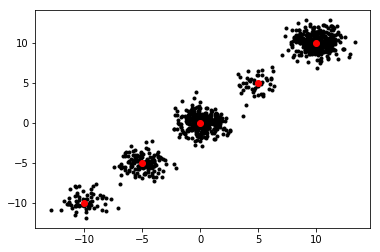

In [3]:
# visualize the data
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_approx):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')
    
print('observed mixture proportions: \n', np.mean(true_z, axis = 0))
print('true mixture proportions: \n', true_pi)

## Set up VB model

In [4]:
global_params = ModelParamsDict('global')
global_params.push_param(
    PosDefMatrixParamVector(name='info', length=k_approx, matrix_size=x_dim)) # variational variances
global_params.push_param(
    ArrayParam(name='mu', shape=(k_approx, x_dim))) # variational means
global_params.push_param(
    DirichletParamArray(name='v_sticks', shape=(k_approx - 1, 2))) # note the shape k_approx - 1 ...
                                                                   # the last stick is always 1 in our approximation
local_params = ModelParamsDict('local')
local_params.push_param(
    SimplexParam(name='e_z', shape=(num_obs, k_approx)))

vb_params = ModelParamsDict('vb_params model')
vb_params.push_param(global_params)
vb_params.push_param(local_params)


In [5]:
prior_params = ModelParamsDict('prior_params')
prior_params.push_param(VectorParam(name='prior_mu', size=x_dim, val=prior_mu))
prior_params.push_param(PosDefMatrixParam(name='prior_info', size=x_dim, val=prior_info))
prior_params.push_param(ScalarParam(name='alpha', val=alpha))
prior_params.push_param(PosDefMatrixParam(name='info_x', size=x_dim, val=info_x))

## Initialize

In [6]:
## initialize VB params

true_init = True
if true_init: 
    true_tau = np.zeros(np.shape(vb_params['global']['v_sticks'].alpha.get()))
    true_tau[:,0] = true_v[:-1] * 100
    true_tau[:,1] = (1 - true_v[:-1]) * 100
    vb_params['global']['v_sticks'].alpha.set(true_tau)

    vb_params['global']['mu'].set(true_mu)
    
    true_z_fudged = dp.soft_thresh(true_z, 1 - 10**(-8), 20**(-8))
    
    vb_params['local']['e_z'].set(true_z_fudged)
    
else: 
    vb_params.set_free(np.random.random(vb_params.free_size()))
    
init_par_vec = vb_params.get_free()
global_init_par_vec = vb_params['global'].get_free()

## Newton Optimization

In [7]:
model = dp.DPNormalMixture(x, vb_params, prior_params)
kl_obj = Objective(model.vb_params['global'], model.kl)

In [8]:
def minimize_kl(kl_obj, init_x):
    vb_opt = optimize.minimize(
        kl_obj.fun_free,
        x0=init_x,
        jac=kl_obj.fun_free_grad,
        hess=kl_obj.fun_free_hessian,
        method='trust-ncg', options={'maxiter': 50, 'gtol': 1e-8, 'disp': True})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec)
print(kl_obj.fun_free(vb_opt.x))

         Current function value: -48639.978743
         Iterations: 20
         Function evaluations: 22
         Gradient evaluations: 20
         Hessian evaluations: 20
done
-48639.978743


In [9]:
model.vb_params['global'].set_free(vb_opt.x)

true_z (unpermuted): 
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]]
** procedure did not give a true permutation
permutation:  [0 1 2 3 4]
true Z (permuted) 
 [[ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.]]
e_z (rounded) 
 [[ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.]]
l1 error (after permutation):  [0.46199924639649154, 0.071874464710283803, 0.39395915684694199, 0.046632317639257542, 0.7392271205471842]


true A (permuted): 
 [[-10. -10.]
 [ 

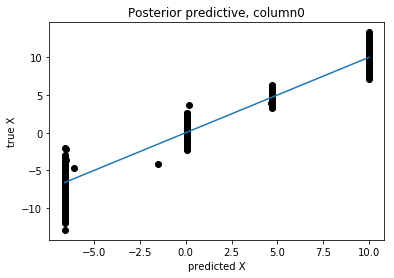

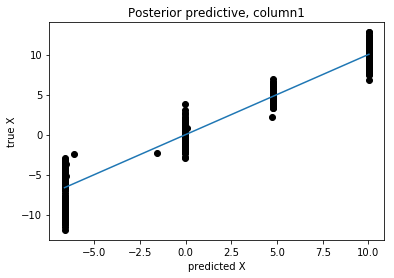

In [10]:
mu = model.vb_params['global']['mu'].get()
model.set_optimal_z()
e_z = model.vb_params['local']['e_z'].get()
dp.display_results(x, true_z, true_mu, e_z, mu, manual_perm = None)

In [13]:
np.dot(prior_mu, prior_info) + np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92459043e+03,   3.93119813e+03],
       [ -1.42691684e+03,  -1.42802797e+03],
       [  2.21420211e+02,   2.23979301e+02],
       [  2.10572804e-04,   6.31267876e-04],
       [  2.48420648e+01,  -1.39977262e+01]])

In [22]:
 np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92559043e+03,   3.93219813e+03],
       [ -1.42591684e+03,  -1.42702797e+03],
       [  2.22420211e+02,   2.24979301e+02],
       [  1.00021057e+00,   1.00063127e+00],
       [  2.58420648e+01,  -1.29977262e+01]])

In [25]:
np.dot(e_z.T, np.dot(x, info_x))

array([[  3.92459043e+03,   3.93119813e+03],
       [ -1.42691684e+03,  -1.42802797e+03],
       [  2.21420211e+02,   2.23979301e+02],
       [  2.10572804e-04,   6.31267876e-04],
       [  2.48420648e+01,  -1.39977262e+01]])

In [27]:
np.sum(e_z, axis = 0)[1]

214.1255354365253

In [28]:
info_update = np.array([prior_info + np.sum(e_z[:, i]) * info_x \
                            for i in range(k_approx)])

In [29]:
info_update

array([[[ 391.99924641,    0.        ],
        [   0.        ,  391.99924641]],

       [[ 215.12553544,    0.        ],
        [   0.        ,  215.12553544]],

       [[  47.01574032,    0.        ],
        [   0.        ,   47.01574032]],

       [[   1.63235751,    0.        ],
        [   0.        ,    1.63235751]],

       [[ 349.22712063,    0.        ],
        [   0.        ,  349.22712063]]])

In [30]:
sum_e_z = np.sum(e_z, axis = 0)

In [31]:
sum_e_z

array([ 390.99924641,  214.12553544,   46.01574032,    0.63235751,
        348.22712063])

In [35]:
cm = np.cumsum(sum_e_z)

In [41]:
np.concatenate(([0.0], cm[:-1]))

array([   0.        ,  390.99924641,  605.12478185,  651.14052216,
        651.77287967])